# 23. A/B Testing a Category Variable with 2 Levels

In [1]:
from datascience import *
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from scipy import stats

We will continue to work with a subset of the `personality` table called `pers`. This time, however, we will focus on a category variable `AccDate` the responses to which are Yes/No based on this question. "At a time in your life when you are not involved with anyone, someone asks you out. This person has a great personality, but you do not find this person physically attractive. Do you accept the date?"

For the special case of a category variable with only two levels, we can use A/B testing. Since the test statistic is slightly different, the process will be quite similar to but not exactly like typical A/B tests with numeric variables.

In [2]:
pers = Table.read_table('http://faculty.ung.edu/rsinn/perfnarc.csv')
pers.show(5)

In [3]:
date = pers.select('Sex','AccDate')
date

Sex  | AccDate
F    | N
F    | Y
F    | N
F    | Y
F    | Y
F    | N
F    | N
F    | Y
F    | Y
F    | Y
... (138 rows omitted)

## Does biological sex affect Yes/No response to dating question?

A pivot table is the perfect data summary to reflect the difference in responses based on biological sex.

In [41]:
date.pivot('AccDate','Sex')

Sex  | N    | Y
F    | 33   | 52
M    | 31   | 32

### Steps in the hypothesis test

1. **Null hypothesis.** The grouping variable is independent of the response variable.
2. **Alternate hypothesis.** The response variable depends upon the grouping variable.
3. **Test statistic**. Simulated number of female Yes responses.
4. Simulate test statistic distribution with sample of 85 responses drawn without replacement.
5. Calculate **$p$-value**, e.g. the probability the null hypothesis is true.
6. **Statistical Conclusion.** If $p<0.05$, reject null. Else, fail to reject null.
7. **Real world implications.** State the results of hypothesis test in real world terms.

### Simulating the null hypothesis

The null hypothesis is that a person's Yes/No response to the dating question is independent of their biological sex. There are 85 female responses. If sex has no bearing on the response, then repeated random draws of 85 responses should reveal whether 52 Yes responses in that group is typical. 

As with the `ab_shuffle` function for A/B testing, the draws must be without replacement.

In [44]:
date.sample(85, with_replacement = False)

Sex  | AccDate
M    | Y
F    | N
F    | N
F    | N
F    | Y
M    | N
F    | N
F    | Y
M    | N
F    | N
... (75 rows omitted)

Our plan is to draw 85 random responses (without replacement) and record the number of Yes responses ignoring biological sex.

In [45]:
new_samp = date.sample(85, with_replacement = False).column(1)
new_samp

array(['N', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y',
       'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N',
       'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N',
       'N', 'Y', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'N', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y',
       'N', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'N',
       'N', 'Y', 'N', 'Y', 'N', 'Y', 'N'], dtype='<U1')

In [46]:
sum(new_samp == 'Y')

49

We now recalculate the statistic a few thousand times with our standard `for` loop setup.`m

In [50]:
yes_count = make_array()

# Set reps to 2,000 or less especially if working the cloud
reps = 50000

for i in range(reps):
    new_samp = date.sample(85, with_replacement = False).column(1)
    new_count = sum(new_samp == 'Y')
    yes_count = np.append(yes_count,new_count)

# Remove hashtag comment below to see the results array
# yes_count

### Results

We can use the `ab_hist` function to display a histogram of the simulated distribution for the statistic and compare 52, the observed number of Yes responses, to it.

In [29]:
def ab_hist(myArray, observed_value):
    tab = Table().with_column('A/B Differencs',myArray)
    tab.hist(0)
    _ = plots.plot([observed_value, observed_value], [0, 0.1], color='red', lw=2)

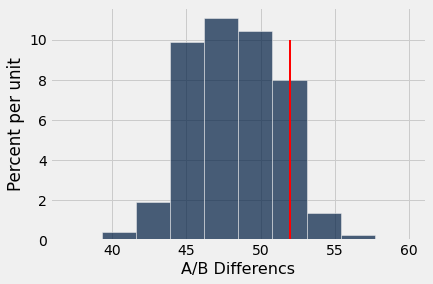

In [53]:
ab_hist(yes_count,52)

In [55]:
p_value = sum( yes_count >= 52) / reps
p_value

0.1383

Because the $p$-value is greater than 0.05, we fail to reject the null hypothesis. We have no evidence that Yes/No responses to the dating question depend on biological sex.

## Dolphin study example

A group of 30 patients experiencing chronic depression were invited to a Caribean island to take part in therapy. The researchers randomly split the group in two. Half of them received clinical treatment for their depression only (along with a huge dose of beach therapy, one presumes). The other half received the same clinical treatment (and beach therapy) plus they went swimming with dolphins.

In [22]:
dolphin = Table.read_table('http://faculty.ung.edu/rsinn/dolphin.csv')
dolphin

Treatment | Result
Dolphins  | Improved
Dolphins  | Improved
Dolphins  | Improved
Dolphins  | Improved
Dolphins  | Improved
Dolphins  | Improved
Dolphins  | Improved
Dolphins  | Improved
Dolphins  | Improved
Dolphins  | Improved
... (20 rows omitted)

In [23]:
dolphin.pivot('Result','Treatment')

Treatment | Did Not | Improved
Control   | 12      | 3
Dolphins  | 5       | 10

````{margin}
```{seealso}
The Rossman-Chance [Dolphin Applet](http://www.rossmanchance.com/applets/ChiSqShuffle.html?dolphins=1) provides a dynamic simulation with visualization. On left, set "Statistic" to "Cell 1 Count", check "Show Shuffle Options" and run up to 100,000 shuffles per click. Set "Count Samples" to "greater than or equal 10" to match our work in this example.
```
````

The researchers want to know whether there is enough evidence to show that the dolphin therapy is significantly better than the clinical and beach therapy option. What null hypothesis will test their claim?

$$H_0: \text{Results are independent of treatment}$$

How could we test it? We can randomly assign the outcomes of Improved or Did Not to a simulated dolphin group. We then check to see how often 10 or more successes land in the randomized dolphin group. The `sample` method creates a table, so we finish with a `column` to produce the output as an array.

In [24]:
dolphin.sample(15, with_replacement = False).column(1)

array(['Improved', 'Did Not', 'Improved', 'Improved', 'Improved',
       'Improved', 'Improved', 'Improved', 'Improved', 'Did Not',
       'Did Not', 'Did Not', 'Did Not', 'Improved', 'Did Not'],
      dtype='<U8')

The following code block selects the simulated dolphin group and counts the number of participants in it who "Improved."

In [26]:
sum( dolphin.sample(15, with_replacement = False).column(1) == 'Improved' )

7

In [35]:
improved_count = make_array()

# Set reps to 2,000 or less especially if working the cloud
reps = 25000

for i in range(reps):
    new_samp = dolphin.sample(15, with_replacement = False).column(1)
    new_count = sum(new_samp == 'Improved')
    improved_count = np.append(improved_count,new_count)

# Remove hashtag comment below to see the results array
# improved_count

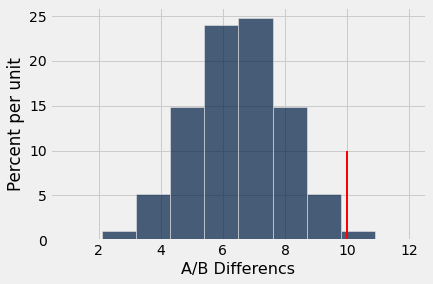

In [36]:
ab_hist(improved_count,10)

In [39]:
p_val = sum (improved_count >= 10) / reps
p_val

0.01264

The $p$-value is less than 0.05 which indicates the null hypothesis is unlikely to be true. Thus, we conclude the dolphin therapy appears to be beneficial to these patients, since a random distribution of the 'Improved' results would be unlikely to produce the observed pattern in the data.